# Logistic Regression: Offensive vs Defensive Players

## Why Logistic Regression?
While the perceptron model performed reasonably well, it has a key limitation: it assumes the data is linearly separable. In real-world scenarios like our player classification task, the boundary between offensive and defensive players isn't always clear-cut. Some players excel in both offensive and defensive attributes, making a strict linear boundary less effective.

Logistic regression addresses this by:
1. Using a sigmoid activation function that provides probability outputs (between 0 and 1)
2. Employing a more sophisticated loss function (cross-entropy)
3. Handling non-linearly separable data better through probabilistic classification

## Our Task
We'll use logistic regression to classify EA FC 24 players as either offensive or defensive based on their attributes. This binary classification task will demonstrate how logistic regression can provide more nuanced predictions compared to the perceptron model.

## Implementation

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

def sigmoid(z):
	return 1.0 / (1.0 + np.exp(-z))

def cross_entropy(y_hat, y):
	return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)

class SingleNeuron(object):
	def __init__(self, activation_function, cost_function):
		self.activation_function = activation_function
		self.cost_function = cost_function

	def train(self, X, y, alpha = 0.005, epochs = 50):
		self.w_ = np.random.rand(1 + X.shape[1])
		self.errors_ = []
		N = X.shape[0]

		for _ in range(epochs):
			errors = 0
			for xi, target in zip(X, y):
				error = (self.predict(xi) - target)
				self.w_[:-1] -= alpha*error*xi
				self.w_[-1] -= alpha*error
				errors += self.cost_function(self.predict(xi), target)
			self.errors_.append(errors/N)
		return self

	def predict(self, X):
		preactivation = np.dot(X, self.w_[:-1]) + self.w_[-1]
		return self.activation_function(preactivation)

## Understanding Our Dataset
Let's examine the key attributes we'll use to distinguish between offensive and defensive players:
- Shooting, Pace, Dribbling (typically higher for offensive players)
- Defending, Physical (typically higher for defensive players)

We would use all 5 attributes to train our model.

At first glance, it might seem like an easy decision for high rated players. However, the dataset also includes low rated players with ratings closer together in the 40-60 range. This makes it more difficult to distinguish between offensive and defensive players. This is where logistic regression's probabilistic approach should prove more effective than the perceptron's hard boundary.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

players_df = pd.read_csv("../data/players_data.csv")

# Define offensive and defensive positions
offensive_positions = ['ST', 'CF', 'LW', 'RW', 'CAM']
defensive_positions = ['CB', 'LB', 'RB', 'CDM', 'LWB', 'RWB']

# Create target variable (1 for offensive, -1 for defensive)
def get_position_class(position_str):
    positions = str(position_str).split(', ')
    if any(pos in offensive_positions for pos in positions):
        return 1
    elif any(pos in defensive_positions for pos in positions):
        return 0
    return None

# Prepare the data
players_df['position_class'] = players_df['player_positions'].apply(get_position_class)

# Filter only offensive and defensive players. We'll remove ambiguous players.
filtered_df = players_df[players_df['position_class'].notna()]

features = ["shooting", "defending", "pace", "dribbling", "physic"]
# Select features for classification
X = filtered_df[features].values
y = filtered_df['position_class'].values

#Scale x because values are too large for our sigmoid and loss function.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

(4433, 5) (4433,)


/var/folders/pz/s1ggtx853xx_qxny9g89ffgm0000gn/T/ipykernel_16606/422180450.py:4: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  players_df = pd.read_csv("../data/players_data.csv")


## Model Training

In [5]:
# Set the Seaborn theme
sns.set_theme()

# Instantiate and train the logistic regression model
clf = SingleNeuron(activation_function=sigmoid, cost_function=cross_entropy)
clf.train(X_train, y_train, epochs=1000)


## Most Weighted Features
Let's analyze which features were most important in our logistic regression model.

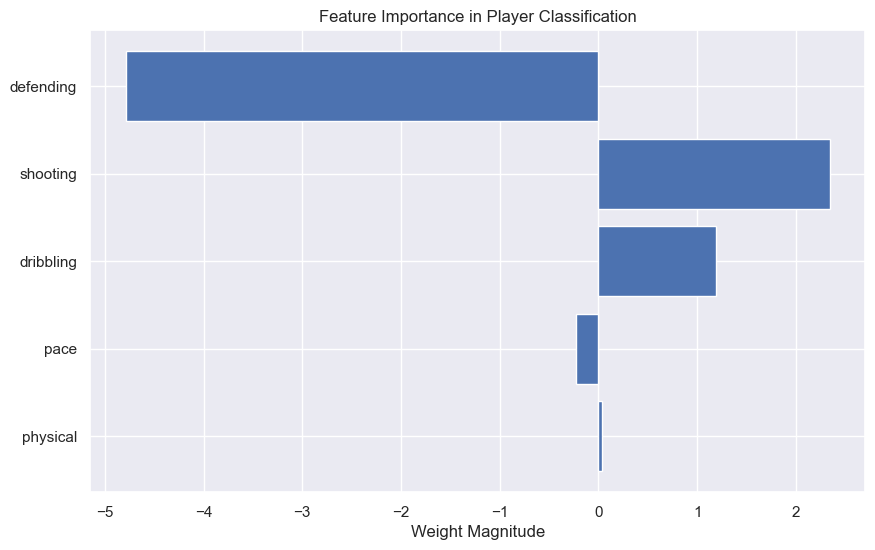

In [6]:
# Feature importance plot
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'Feature': ['shooting', 'defending', 'pace', 'dribbling', 'physical'],
    'Weight': clf.w_[:-1]  # excluding bias weight
})
feature_importance = feature_importance.sort_values('Weight', ascending=True, key=abs)

plt.barh(feature_importance['Feature'], feature_importance['Weight'])
plt.title('Feature Importance in Player Classification')
plt.xlabel('Weight Magnitude')
plt.show()

## Model Performance Evaluation

Let's evaluate our model's performance using a confusion matrix and classification report.

We see a high accuracy of 94%. Our logistic model is a significant improvement over the perceptron model.

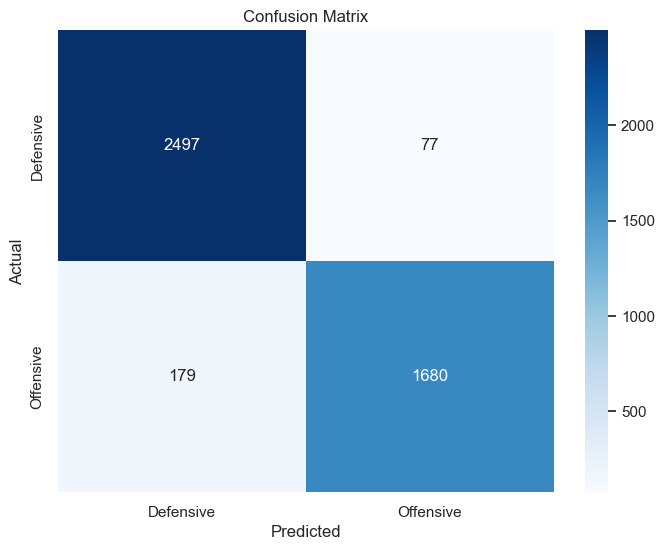


Classification Report:
              precision    recall  f1-score   support

   Defensive       0.93      0.97      0.95      2574
   Offensive       0.96      0.90      0.93      1859

    accuracy                           0.94      4433
   macro avg       0.94      0.94      0.94      4433
weighted avg       0.94      0.94      0.94      4433



In [7]:
# Calculate and display confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

y_hat = np.where(clf.predict(X_test) >= 0.5, 1, 0)

# Create confusion matrix
cm = confusion_matrix(y_test, y_hat)

# Create labels for the classes
class_labels = ['Defensive', 'Offensive']

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_hat, target_names=class_labels))

## Actual vs Predicted Scatter Plot

Let's visualize how our logistic regression model classifies players based on their most important features.

We see better results than the perceptron model.

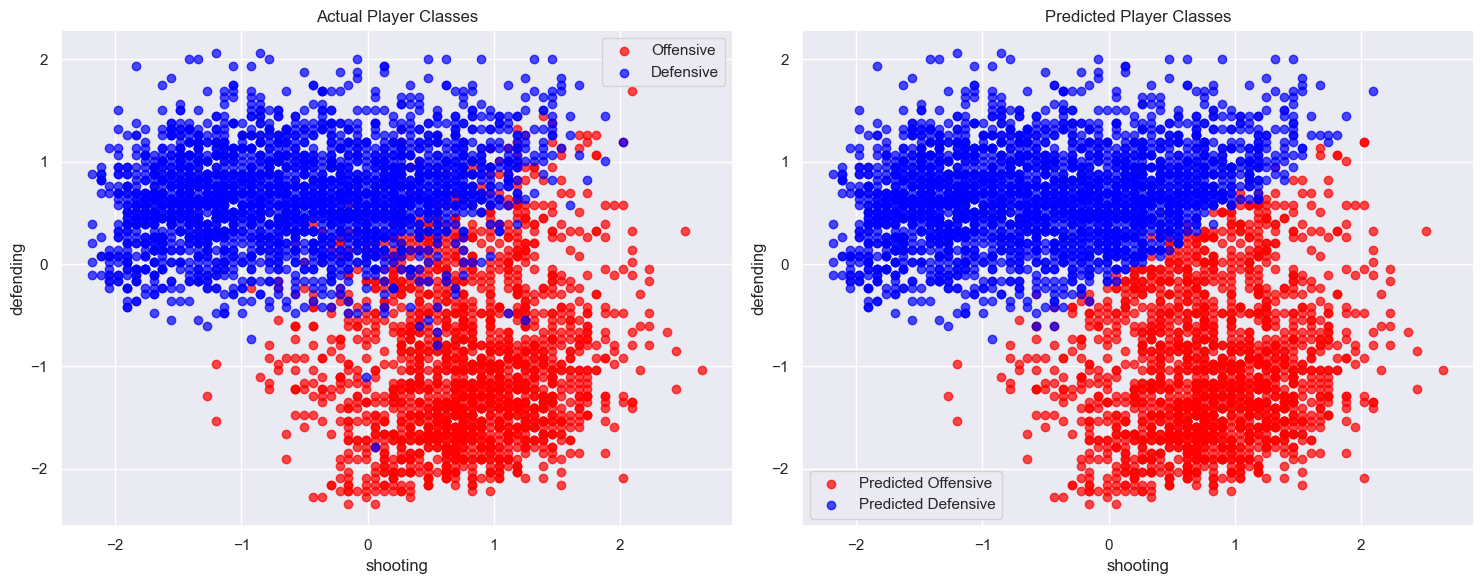

In [9]:
# Create two subplots side by side
plt.figure(figsize=(15, 6))

# First subplot - Actual classes
plt.subplot(1, 2, 1)
top_features = feature_importance.tail(2)['Feature'].values

# Plot actual offensive players (y_test == 1) in red
plt.scatter(X_test[y_test == 1, 0], 
           X_test[y_test == 1, 1],
           label='Offensive', alpha=0.7, color='red')

# Plot actual defensive players (y_test == -1) in blue
plt.scatter(X_test[y_test == 0, 0], 
           X_test[y_test == 0, 1],
           label='Defensive', alpha=0.7, color='blue')

plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.title('Actual Player Classes')
plt.legend()

# Second subplot - Predicted classes
plt.subplot(1, 2, 2)

# Plot predicted offensive players (y_hat == 1) in red
plt.scatter(X_test[y_hat == 1, 0], 
           X_test[y_hat == 1, 1],
           label='Predicted Offensive', alpha=0.7, color='red')

# Plot predicted defensive players (y_hat == -1) in blue
plt.scatter(X_test[y_hat == 0, 0], 
           X_test[y_hat == 0, 1],
           label='Predicted Defensive', alpha=0.7, color='blue')

plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.title('Predicted Player Classes')
plt.legend()

plt.tight_layout()
plt.show()